In [1]:
# !pip install ipympl > /dev/null
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## "Imports"
- ChunkedNPTStackReader
- butter_bandpass_filter(arr[:, 0], 20e3, 100e3, fs, 6)
- Est_ZC_stage_1

In [2]:
import numpy as np
import struct

class ChunkedNPTStackReader:
    def __init__(self, filename, delimiter=','):
        self.filename = filename
        self.file = None
        self.time_len = struct.calcsize('<d')
        self.time_unpack = struct.Struct('<d').unpack_from

    def __enter__(self):
        print("Opening npstack file")
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
        return self

    def __iter__(self):
        return self

    def __next__(self):
        if self.file is None:
            raise Exception("Use the context manager interface with this object, i.e. ```with ChunkedNPStackReader('output.csv') as cr: ```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))
            arr = np.load(self.file)
            return t, arr
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def stream(self):
        return np.vstack([arr for arr in self])

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.file.close()


## Get Data

In [3]:
!ls ../data/full/nuc_adapter_1/pico.npts

../data/full/nuc_adapter_1/pico.npts


In [4]:
input_file = '../data/full/nuc_adapter_1/pico.npts'

In [5]:
with ChunkedNPTStackReader(input_file) as file:
  arr = np.vstack(tuple(a[1] for a in file))
arr.shape

Opening npstack file


(11300000, 5)

In [6]:
_[0]/(1e6)

11.3

In [11]:
# data_archive.close()

In [12]:
np.max(np.abs(arr)), arr.dtype

(2000, dtype('int16'))

In [9]:
dt = 1e-6
fs = 1.0 / dt
print(f"dt={dt}\tfs={fs:.0f}Hz")
print(f"Total Time: {arr.shape[0] * dt:.2f}s")

t = np.arange(len(arr)) * dt

dt=1e-06	fs=1000000Hz
Total Time: 11.30s


## BandPass Tests

In [ ]:
from scipy.signal import iirfilter, sosfilt

In [ ]:
order = 6
pass_freqs = np.array((20e3, 50e3))

arr_filtered = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr)

In [ ]:
plt.figure(figsize=(12,3))
loc = slice(0, len(arr)//50)
_ = plt.plot(1000 * t[loc], arr_filtered[loc, :])#, label=list(np.arange(arr.shape[1])))
plt.legend(_, map(lambda x: f"Ch{x}", np.arange(arr.shape[1]) + 1))
plt.xlabel('T(ms)')
# plt.ylabel('A')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
loc = slice(0, len(arr)//10)
# channels = slice(0, arr.shape[1])
channels = slice(0, 5)
_ = plt.plot(1000 * t[loc], arr_filtered[loc,channels])#, label=list(np.arange(arr.shape[1])))
plt.legend(_, map(lambda x: f"Ch{x}", np.arange(arr.shape[1]) + 1), loc='lower right')
plt.xlabel('T(ms)')
# plt.ylabel('A')
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(0, len(arr)//5)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("T(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(20,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(0, len(arr)//50)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(1000 * t[loc], row[loc], label=f"Ch{i+1}", color=color)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("T(ms)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(20,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(0, len(arr)//100)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(1000 * t[loc], row[loc], label=f"Ch{i+1}", color=color)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("T(ms)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
order = 6
pass_freqs = np.array((20, 20.01)) * int(1e3)
 
arr_filtered = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr)

In [ ]:
plt.figure(figsize=(12,3))

plt.plot(t[:len(arr)//100], arr_filtered[:len(arr)//100, :])

plt.show()

In [ ]:
order = 6
pass_freqs = np.array((200, 200.01)) * int(1e3)
 
arr_filtered = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr)

In [ ]:
plt.figure(figsize=(12,3))

plt.plot(t[:len(arr)//100], arr_filtered[:len(arr)//100, :])

plt.show()

## Bandpass better

In [ ]:
from scipy.signal import iirfilter, sosfilt

In [ ]:
arr.mean(axis=0)

array([-2.01782805e+02, -1.92256579e+02, -1.75069420e+02,  7.44519085e-02,
       -1.05052654e+02])

In [ ]:
order = 6
pass_freqs = np.array((4e3, 44e3))

arr_filtered = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr[int(5*fs):int(10*fs)] - arr[int(5*fs):int(10*fs)].mean(axis=0))

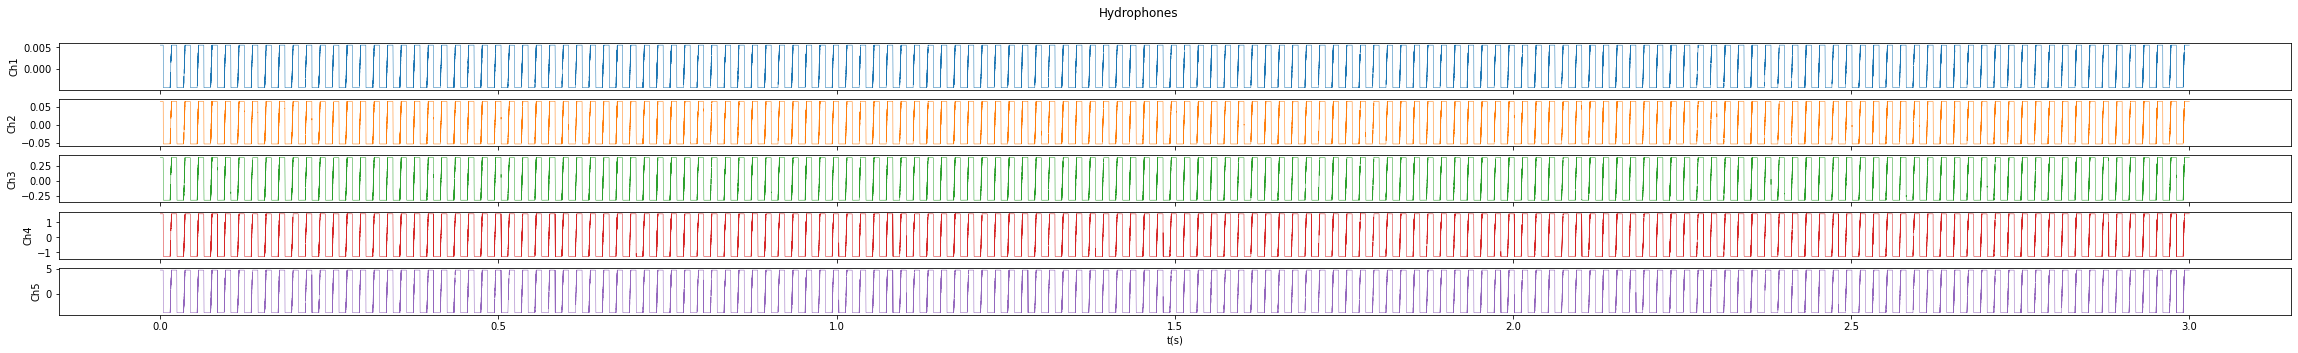

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(0, int(3.0 / dt))
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.5)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
print(arr.shape, loc)

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(1*len(arr)//5, 2*len(arr)//5)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
from scipy.signal import iirfilter, lfilter, hilbert

In [ ]:
order = 6
pass_freqs = np.array((43e3, 47e3))

arr_filtered = lfilter(
    *iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='ba'), 
    arr)

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(0, len(arr)//5)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
# f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(2*len(arr)//5, 3*len(arr)//5)
# for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
#   ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
#   ax.set_ylabel(f"Ch{i+1}")

# ax.set_xlabel("t(s)")
# f.suptitle("Hydrophones")
# plt.show()

In [ ]:
arr_env = np.abs(hilbert(arr_filtered))

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(2*len(arr)//5, 3*len(arr)//5)
loc = slice(1*len(arr)//5, 2*len(arr)//5)
for (i, ax), row, color in zip(enumerate(axs), arr_env.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(2*len(arr)//5, 3*len(arr)//5)
loc = slice(int(6.6 // dt), int(6.8 // dt))
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(2*len(arr)//5, 3*len(arr)//5)
loc = slice(int(6.6 // dt), int(6.8 // dt))
for (i, ax), row, color in zip(enumerate(axs), arr_env.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

0

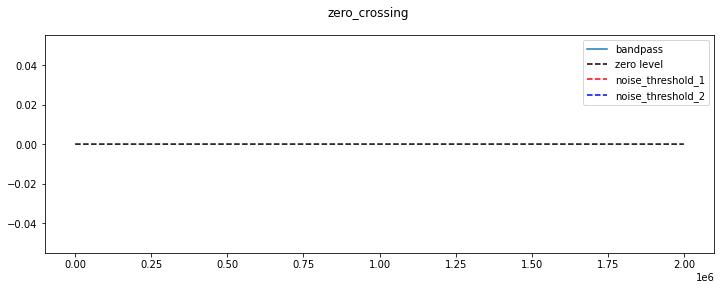

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),0], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

In [ ]:
_ * dt

0.0

0

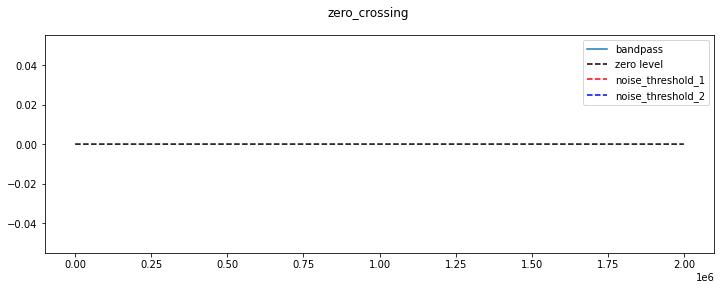

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),1], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

0

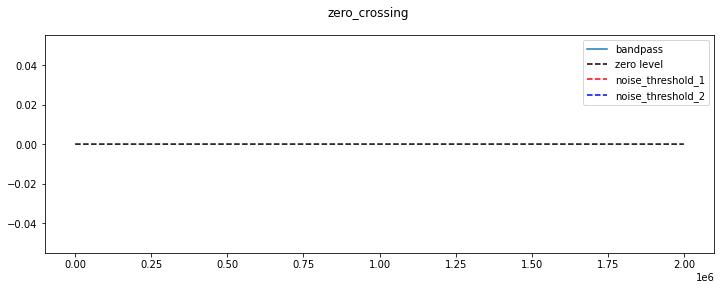

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),2], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

0

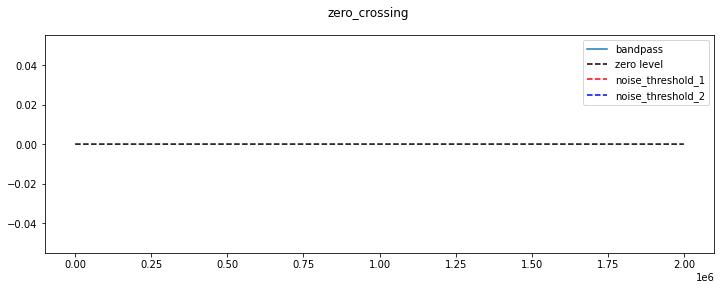

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),3], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

0

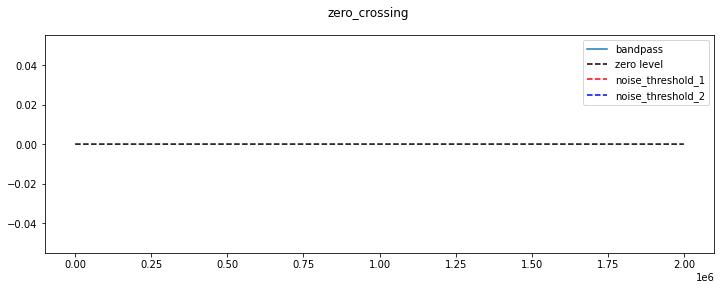

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),4], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

In [ ]:
indices = np.array([415423, 415596, 415596, 415729, 415432])

In [ ]:
ts = indices * dt

In [ ]:
ts

In [ ]:
min(_)

In [ ]:
ind = np.array([0.415596, 0.415596, 0.415729]) - 0.41523

In [ ]:
ind  * 1500

In [ ]:
0.6 * np.sqrt(2)

## Remove AC Noise

In [7]:
import pywt
from scipy.signal import iirfilter, sosfilt, hilbert

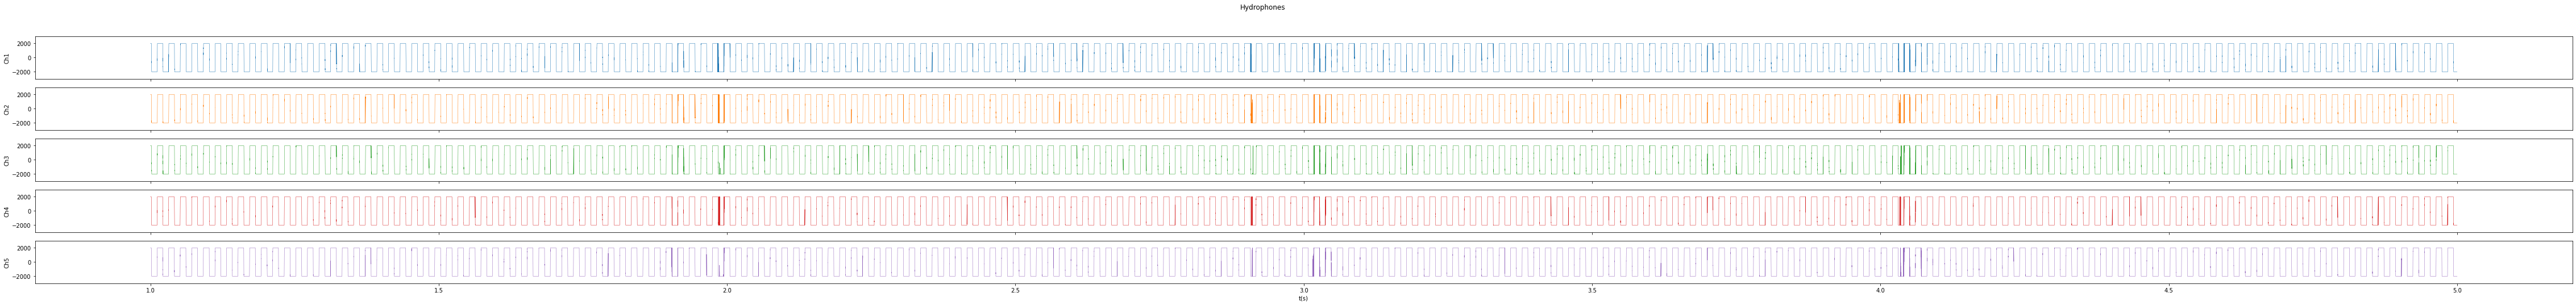

In [10]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(80,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(int(10.0 / dt), int(13.0 / dt))
loc = slice(int(1.0 / dt), int(5.0 / dt))
for (i, ax), row, color in zip(enumerate(axs), arr.T, colors):
  ax.plot(t[loc], row[loc] - row.mean(), label=f"Ch{i+1}", color=color, linewidth=0.5)
  ax.set_ylabel(f"Ch{i+1}")
  ax.set_ylim(-3000,3000)

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [11]:
order = 6
pass_freqs = np.array((40e3, 50e3))

arr_filt = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr - arr.mean(axis=0))

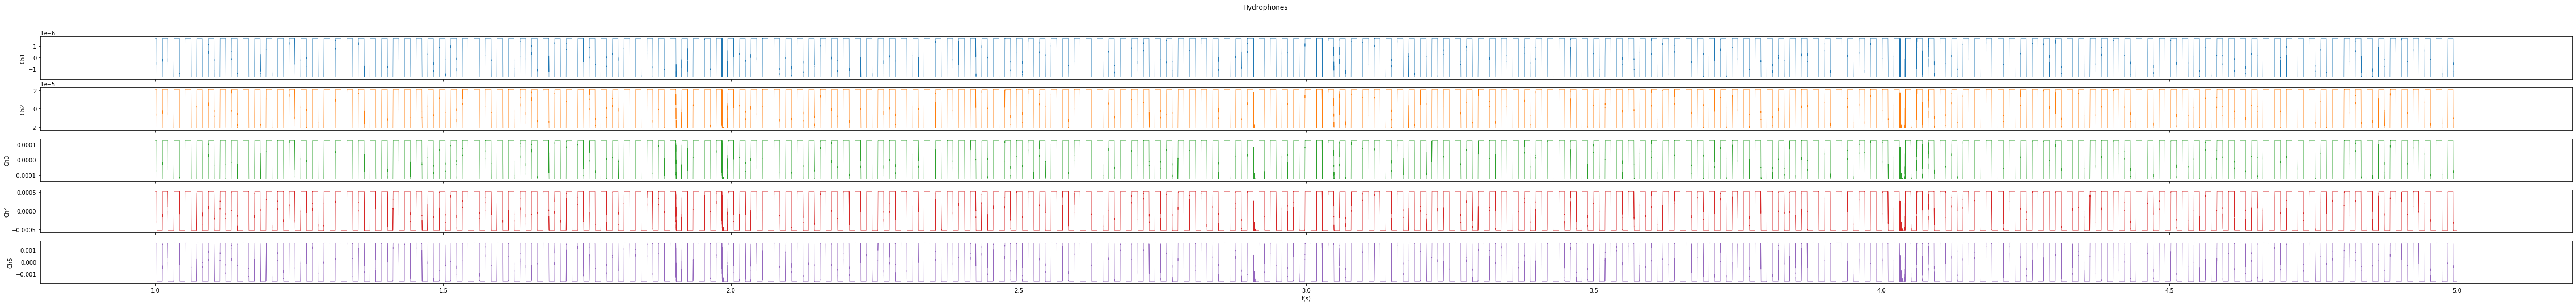

In [12]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(80,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(int(10.0 / dt), int(13.0 / dt))
loc = slice(int(1.0 / dt), int(5.0 / dt))

for (i, ax), row, color in zip(enumerate(axs), arr_filt.T, colors):
  ax.plot(t[loc], row[loc] - row.mean(), label=f"Ch{i+1}", color=color, linewidth=0.5)
  ax.set_ylabel(f"Ch{i+1}")
#   ax.set_ylim(-3000,3000)

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [15]:
loc = slice(int(fs * 1), int(fs * 5))
data = arr[loc, 0]
ts = t[loc]

data.shape,data.mean()

((4000000,), 8.45025525)

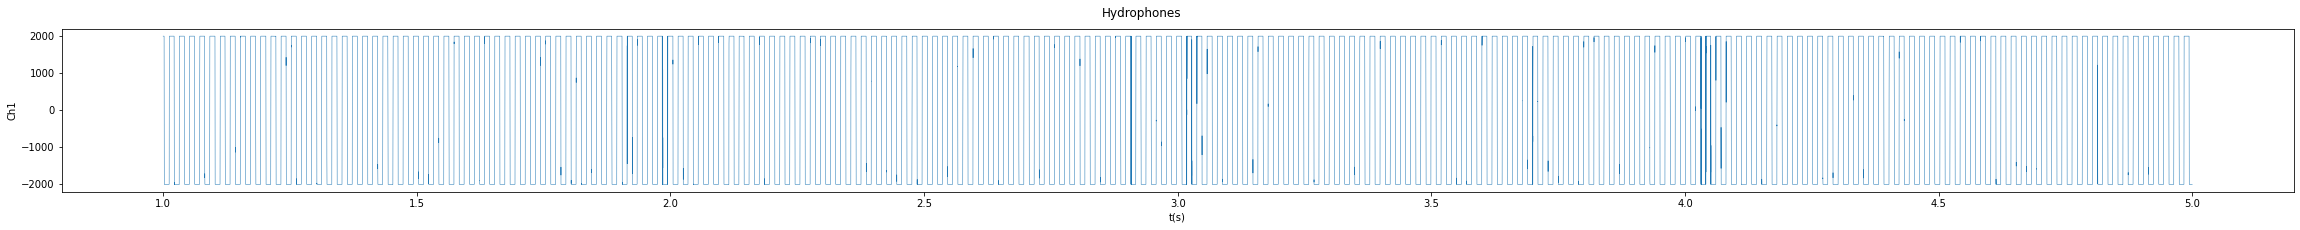

In [16]:
f = plt.figure(figsize=(40,3))
ax = f.gca()
loc = slice(int(1.0 / dt), int(5.0 / dt))
ax.plot(ts, data,  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [17]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
f[-1], f[0]

(50.00000000000001, 50000.00000000001)

In [18]:
coef, freqs=pywt.cwt(data,scale, 'mexh', sampling_period=dt, method='fft')


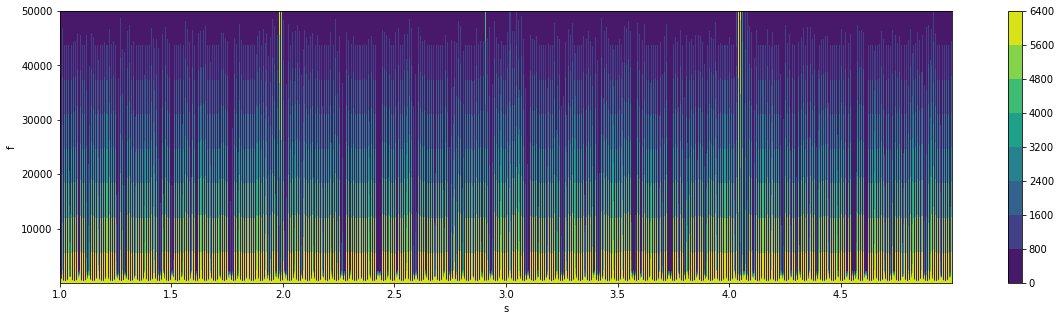

In [19]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], freqs, np.clip(np.abs(coef[:, ::500]), 0, 6000))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()

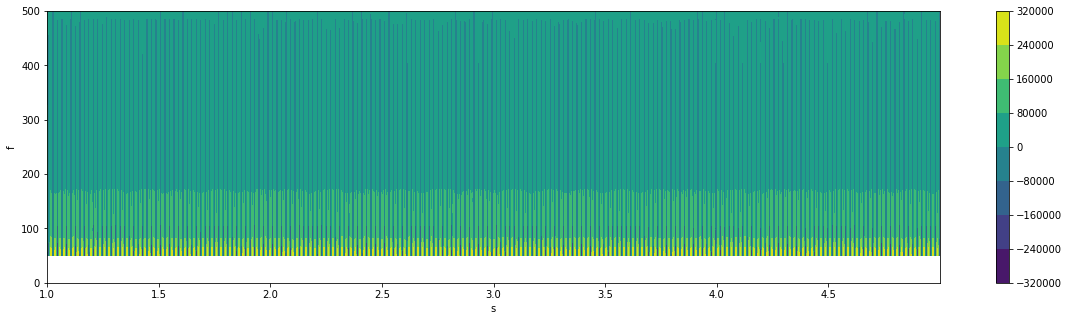

In [20]:
plt.figure(figsize=(20,5))
plt.contourf(t[loc][::500], f, coef[:, ::500])
plt.xlabel('s')
plt.ylabel('f')
plt.ylim(0, 500)
plt.colorbar()

In [21]:
order = 6
pass_freqs = np.array((40e3, 50e3))

lp_data = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    data - data.mean())

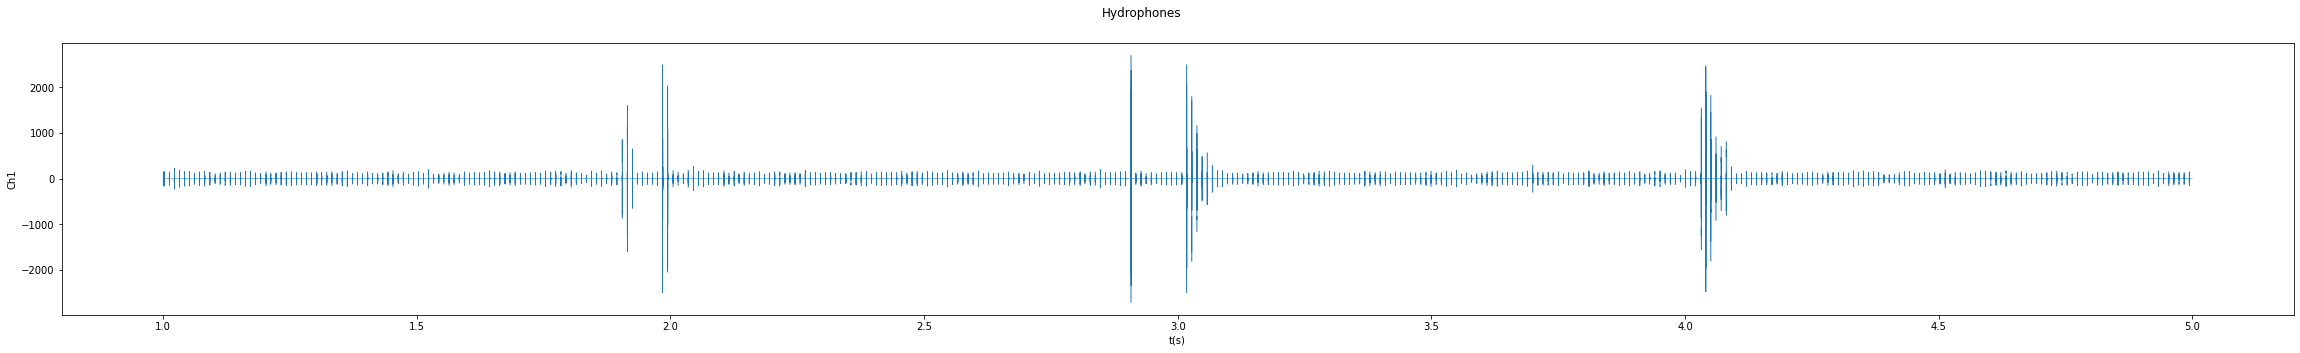

In [22]:
f = plt.figure(figsize=(40,5))
ax = f.gca()
loc = slice(0, data.shape[0] // 5)
ax.plot(ts, lp_data,  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [23]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
print(f[-1], f[0])
coef, freqs=pywt.cwt(lp_data,scale, 'mexh', sampling_period=dt, method='fft')

50.00000000000001 50000.00000000001


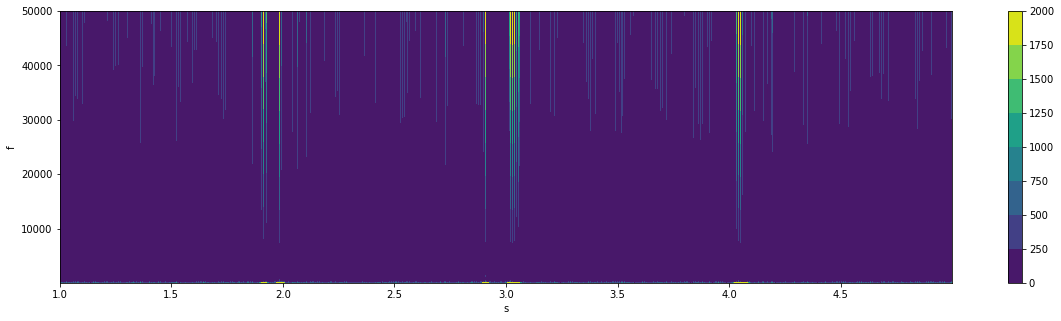

In [24]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], f, np.clip(np.abs(coef[:, ::500]), 0, 2000))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], f, np.clip(np.abs(coef[:, ::500] / freqs[:, None]), 0, 0.1))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], f, np.clip(np.abs(coef[:, ::500] / freqs[:, None]), 0, 50))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()
plt.ylim(10, 500)

In [ ]:
scale = np.linspace(1,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
print(f[-1], f[0])
coef, freqs=pywt.cwt(lp_data,scale, 'mexh', sampling_period=dt, method='fft')

Text(0, 0.5, 'f')

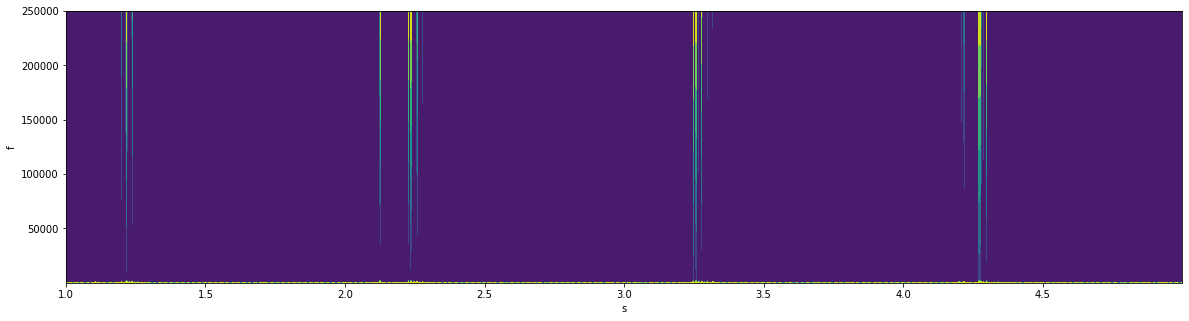

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], f, np.clip(np.abs(coef[:, ::500]), 0, 100))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')

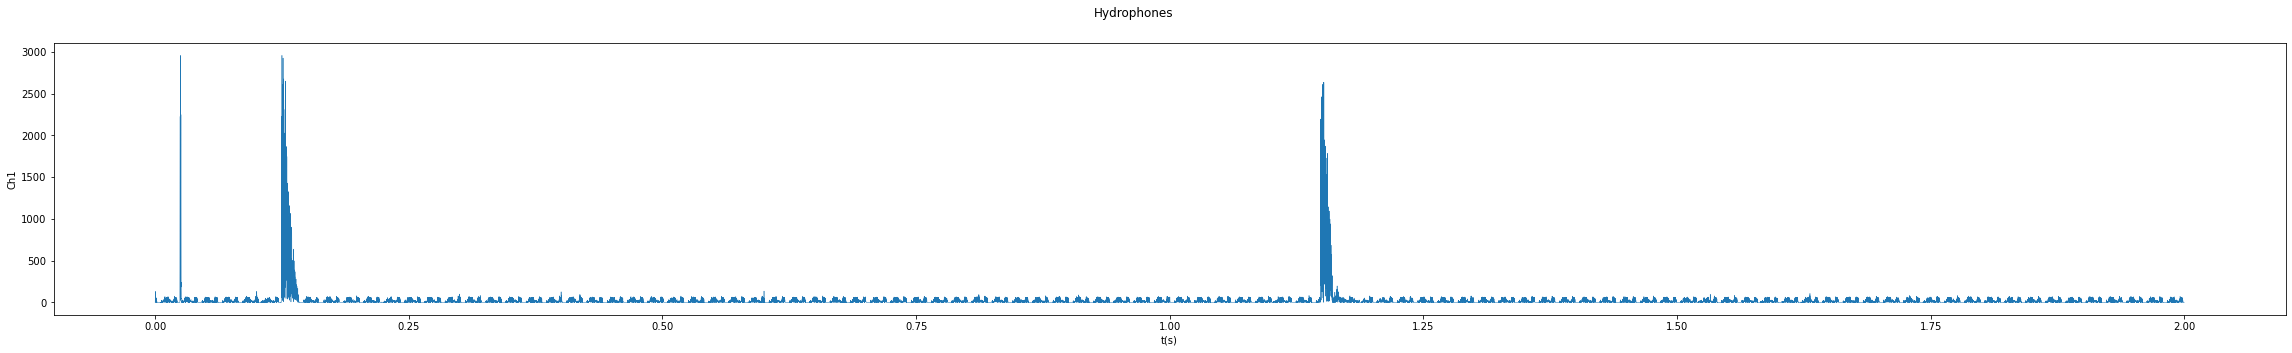

In [ ]:
f = plt.figure(figsize=(40,5))
ax = f.gca()
loc = slice(0, data.shape[0] // 5)
ax.plot(t[loc],np.abs(hilbert(lp_data[loc])),  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

Signal is wide band, hence the hilbert transform wont work.

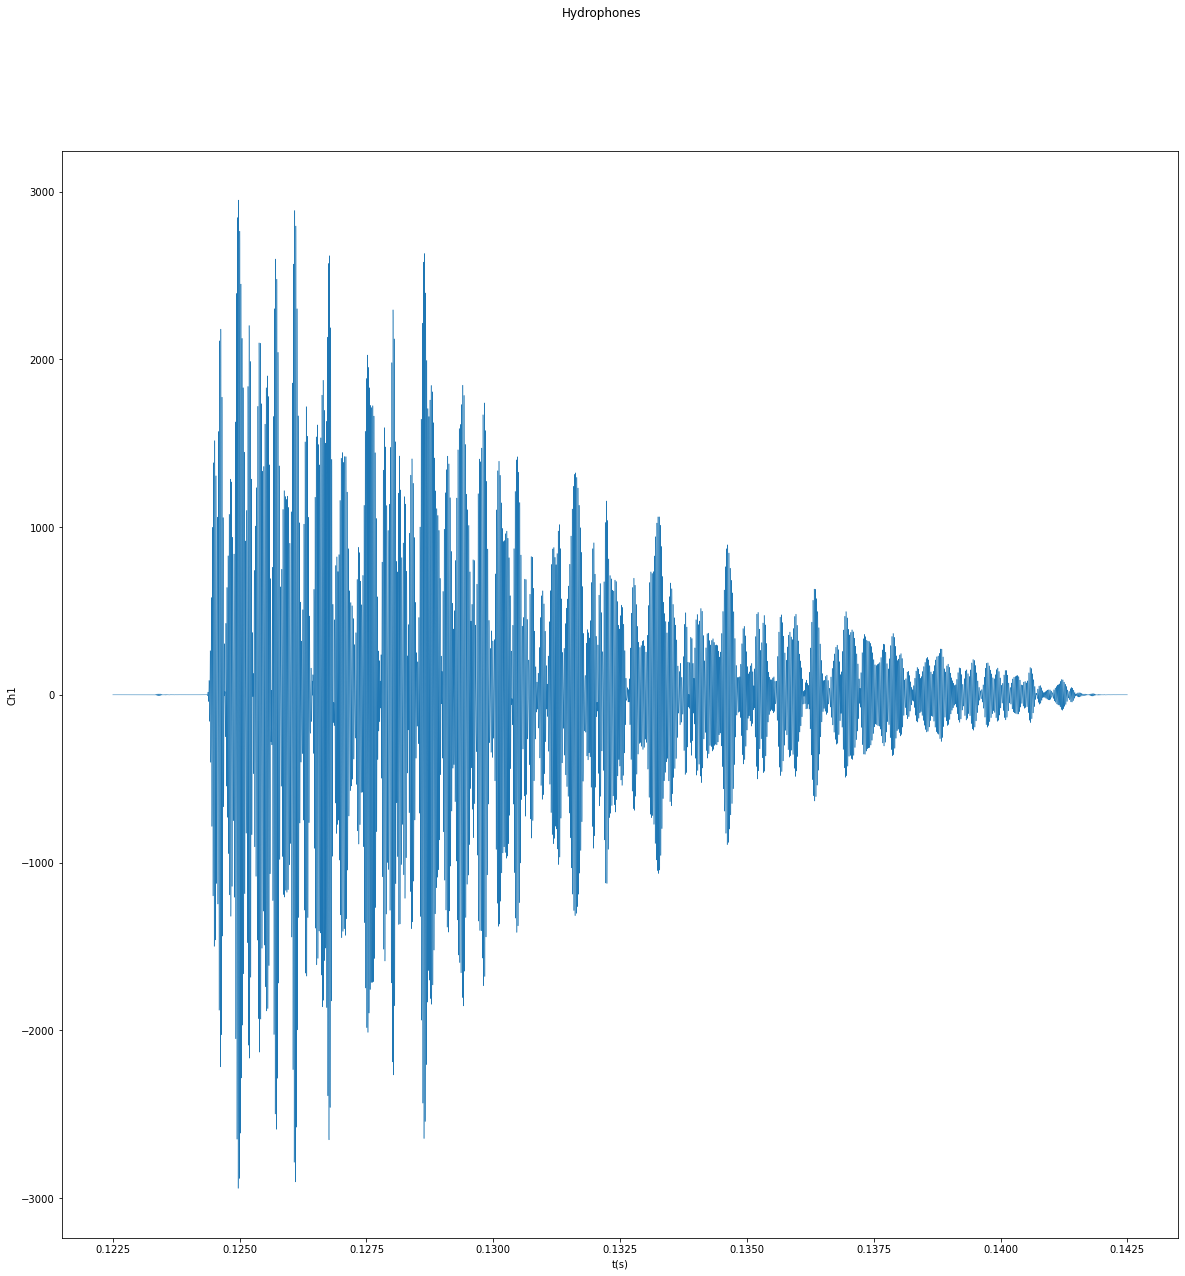

In [ ]:
f = plt.figure(figsize=(20,20))
ax = f.gca()
loc = slice(int(fs * 0.1225), int(fs * 0.1425))
ax.plot(t[loc],lp_data[loc],  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

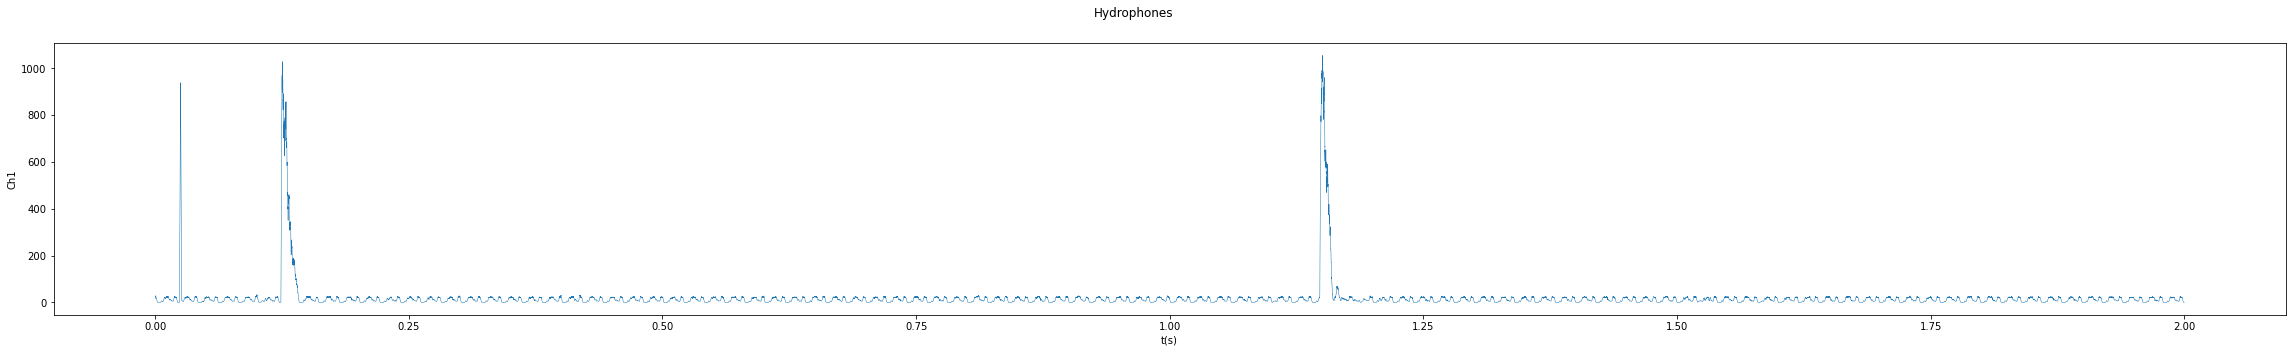

In [ ]:
loc = slice(0, data.shape[0] // 5)

w = int(1e-3 * fs)
sig = np.convolve(np.abs(lp_data[loc]), np.ones(w), 'same') / w

f = plt.figure(figsize=(40,5))
ax = f.gca()
ax.plot(t[loc], sig,  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()